Celem ninejszego notatnika jest zaprezentowanie porównania wyników PCA na zbiorze ,,wine'' w porównaniu z wynikami uzyskanymi dzięki vae i vanilla autoencoder. 

In [25]:
from data_helper_wine import get_dataloaders_and_standarscaler_wine
from train_helper_wine import train_vae
from plot_helper_wine import plot_training_loss

import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [26]:
# Hyperparameters
#RANDOM_SEED = 123
LEARNING_RATE = 0.0005
BATCH_SIZE = 8
NUM_EPOCHS = 1000

In [27]:
CUDA_DEVICE_NUM=0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

Device: cpu


In [28]:
#POBRANIE DANYCH I ICH PRZYGOTOWANIE

#POBIERANIE ONLINE
# df_wine = pd.read_csv('https://archive.ics.uci.edu/'
#                       'ml/machine-learning-databases/wine/wine.data',
#                       header=None)


#ODCZYTANIE DANYCH OFFLINE
path='DATA/wine.data'
df_wine = pd.read_csv('DATA/wine.data', header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

df_wine.head()#zawsze warto rzucić okiem na dane



,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [29]:
train_loader, valid_loader, test_loader, stdcs = get_dataloaders_and_standarscaler_wine(path=path,
    batch_size=BATCH_SIZE, 
    num_workers=0,
    test_fraction=0.2, 
    validation_fraction=0.0)

In [30]:
#TWORZENIE ITERATORA PRZYDATNEGO W PĘTLI UCZĄCEJ MODELU
dataiter_train=iter(train_loader)
data_train=dataiter_train.next()
features_train, labels_train = data_train
#print(features_train, labels_train)

print(features_train.shape[0])

#TWORZENIE ITERATORA ZBIORU TESTOWEGO 
dataiter_test=iter(test_loader)
data_test=dataiter_test.next()
features_test, labels_test = data_test
print(features_test.shape[0])

8
8


In [31]:
#MODEL NASZEJ SIECI 13->13->7->3
class VAE_Linear(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Linear(13, 13),
            nn.BatchNorm1d(13),
            nn.ReLU(),
            nn.Linear(13, 13),
            nn.BatchNorm1d(13),
            nn.ReLU(),
            nn.Linear(13,9),
            nn.BatchNorm1d(9),
            nn.ReLU(),
            # nn.Linear(13, 13),
            nn.BatchNorm1d(9),
            # nn.ReLU(),
            # nn.Linear(13, 7),
            # nn.BatchNorm1d(7),
            # nn.ReLU(),
            # nn.Linear(7, 3),
            # nn.BatchNorm1d(3),
        )

        self.z_mean=nn.Sequential(
            torch.nn.Linear(9,9),
            #nn.BatchNorm1d(3),
            #nn.ReLU(),
            #nn.Linear(3,3)
            )

        self.z_log_var=nn.Sequential(
            torch.nn.Linear(9,9),
           # nn.BatchNorm1d(3),
            #nn.ReLU(),
            #nn.Linear(3,3)
            )
        
        self.decoder = nn.Sequential(
           # nn.Linear(3, 3),
           # nn.BatchNorm1d(3),
            #nn.ReLU(),
            nn.Linear(9, 9),
            #nn.BatchNorm1d(11),
            nn.ReLU(),
            nn.Linear(9,13),
            nn.BatchNorm1d(13),
            nn.ReLU(),
            # nn.ReLU(),
            nn.Linear(13, 13),
            nn.BatchNorm1d(13),
            nn.ReLU(),
            # nn.ReLU(),
            nn.Linear(13, 13),
            nn.BatchNorm1d(13)
            
           # nn.Sigmoid()
        )
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())#get_device dziala tylko dla tensoróœ z gpu
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z

    def reparameterize_for_cpu(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to('cpu')#get_device dziala tylko dla tensoróœ z gpu
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z

    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize_for_cpu(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

In [32]:
model = VAE_Linear()
model.to(DEVICE)

#criterion = nn.MSELoss()#FUNKCJA STRATY
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

In [33]:
log_dict=train_vae(num_epochs=NUM_EPOCHS, device=DEVICE, model=model,optimizer=optimizer,train_loader=train_loader,loss_fn=None, test_loader=test_loader, logging_interval=5)

Epoch: 001/1000 | Batch 0000/0017 | Loss: 27.1679
Epoch: 001/1000 | Batch 0005/0017 | Loss: 36.0915
Epoch: 001/1000 | Batch 0010/0017 | Loss: 32.3562
Epoch: 001/1000 | Batch 0015/0017 | Loss: 29.2906
***Epoch: 001/1000 | Loss: 14.026
Test***Epoch: 001/1000 | Loss: 14.989
Time elapsed: 0.00 min
Epoch: 002/1000 | Batch 0000/0017 | Loss: 33.1334
Epoch: 002/1000 | Batch 0005/0017 | Loss: 28.9116
Epoch: 002/1000 | Batch 0010/0017 | Loss: 34.7492
Epoch: 002/1000 | Batch 0015/0017 | Loss: 22.3577
***Epoch: 002/1000 | Loss: 17.954
Test***Epoch: 002/1000 | Loss: 17.965
Time elapsed: 0.00 min
Epoch: 003/1000 | Batch 0000/0017 | Loss: 22.0644
Epoch: 003/1000 | Batch 0005/0017 | Loss: 25.0207
Epoch: 003/1000 | Batch 0010/0017 | Loss: 22.6590
Epoch: 003/1000 | Batch 0015/0017 | Loss: 24.4076
***Epoch: 003/1000 | Loss: 23.375
Test***Epoch: 003/1000 | Loss: 21.854
Time elapsed: 0.01 min
Epoch: 004/1000 | Batch 0000/0017 | Loss: 28.0011
Epoch: 004/1000 | Batch 0005/0017 | Loss: 30.6748
Epoch: 004/1000

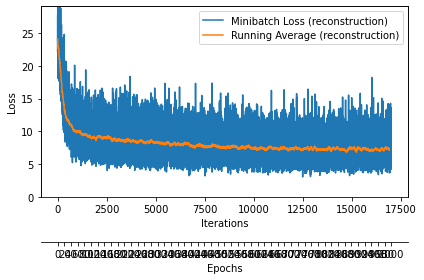

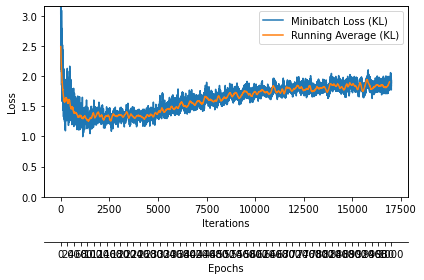

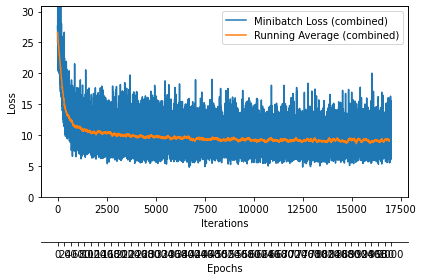

In [34]:
plot_training_loss(log_dict['train_reconstruction_loss_per_batch'], NUM_EPOCHS, custom_label=" (reconstruction)")
plot_training_loss(log_dict['train_kl_loss_per_batch'], NUM_EPOCHS, custom_label=" (KL)")
plot_training_loss(log_dict['train_combined_loss_per_batch'], NUM_EPOCHS, custom_label=" (combined)")
plt.show()



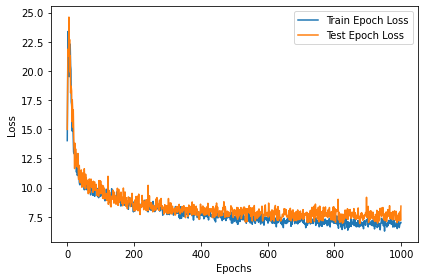

In [35]:
plt.plot(range(len(log_dict['train_combined_loss_per_epoch'])), (log_dict['train_combined_loss_per_epoch']), label='Train Epoch Loss')
plt.plot(range(len(log_dict['test_combined_loss_per_epoch'])), (log_dict['test_combined_loss_per_epoch']), label='Test Epoch Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim(0.15,0.3)
plt.tight_layout()

In [36]:
tmp=df_wine.to_numpy(dtype=np.float32)
tmp=tmp[:,1:]
orginal=copy.deepcopy(tmp)
tmp=stdcs.transform(tmp)
tmp=torch.from_numpy(tmp)
#print(tmp)
with torch.no_grad():
    result_encoded_features, z_mean, z_log_var, result_decoded_features =model(tmp.to(device=DEVICE))
result=result_decoded_features.cpu().detach().numpy()
result=stdcs.inverse_transform(result)

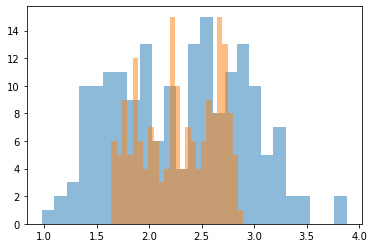

In [50]:
plt.hist(orginal[:,5],bins=25, label ='orginal',alpha=0.5)
plt.hist(result[:,5],bins=25, label ='encoded', alpha=0.5)
plt.show()

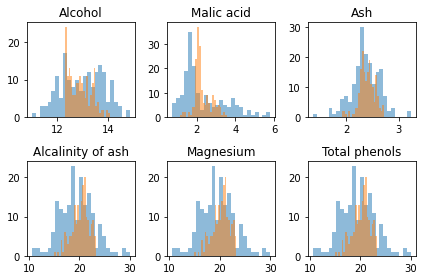

In [55]:
# 'Class label', 'Alcohol', 'Malic acid', 'Ash',
#                    'Alcalinity of ash', 'Magnesium', 'Total phenols',
#                    'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
#                    'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
#                    'Proline'

fig, axs = plt.subplots(2, 3)
axs[0, 0].hist(orginal[:,0],bins=25, label ='orginal',alpha=0.5)
axs[0, 0].hist(result[:,0],bins=25, label ='encoded', alpha=0.5)
axs[0, 0].set_title('Alcohol')
axs[0, 1].hist(orginal[:,1],bins=25, label ='orginal',alpha=0.5)
axs[0, 1].hist(result[:,1],bins=25, label ='encoded', alpha=0.5)
axs[0, 1].set_title('Malic acid')
axs[0, 2].hist(orginal[:,2],bins=25, label ='orginal',alpha=0.5)
axs[0, 2].hist(result[:,2],bins=25, label ='encoded', alpha=0.5)
axs[0, 2].set_title('Ash')
axs[1, 0].hist(orginal[:,3],bins=25, label ='orginal',alpha=0.5)
axs[1, 0].hist(result[:,3],bins=25, label ='encoded', alpha=0.5)
axs[1, 0].set_title('Alcalinity of ash')
axs[1, 1].hist(orginal[:,3],bins=25, label ='orginal',alpha=0.5)
axs[1, 1].hist(result[:,3],bins=25, label ='encoded', alpha=0.5)
axs[1, 1].set_title('Magnesium')
axs[1, 2].hist(orginal[:,3],bins=25, label ='orginal',alpha=0.5)
axs[1, 2].hist(result[:,3],bins=25, label ='encoded', alpha=0.5)
axs[1, 2].set_title('Total phenols')

# for ax in axs.flat:
#     ax.set(xlabel='x-label', ylabel='y-label')

# # Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()
fig.tight_layout()

In [38]:
decoded_df=pd.DataFrame(result,columns=['Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline'])
orginal_df=df_wine.iloc[:,1:]


concatenated_datasets=pd.concat([orginal_df.assign(dataset_name='orginal'), decoded_df.assign(dataset_name='encoded')],ignore_index=True)
concatenated_datasets.shape
print(concatenated_datasets.index.is_unique)

True


In [39]:
# sns.pairplot(concatenated_datasets, hue="dataset_name", kind="scatter", plot_kws=dict(alpha=0.5))

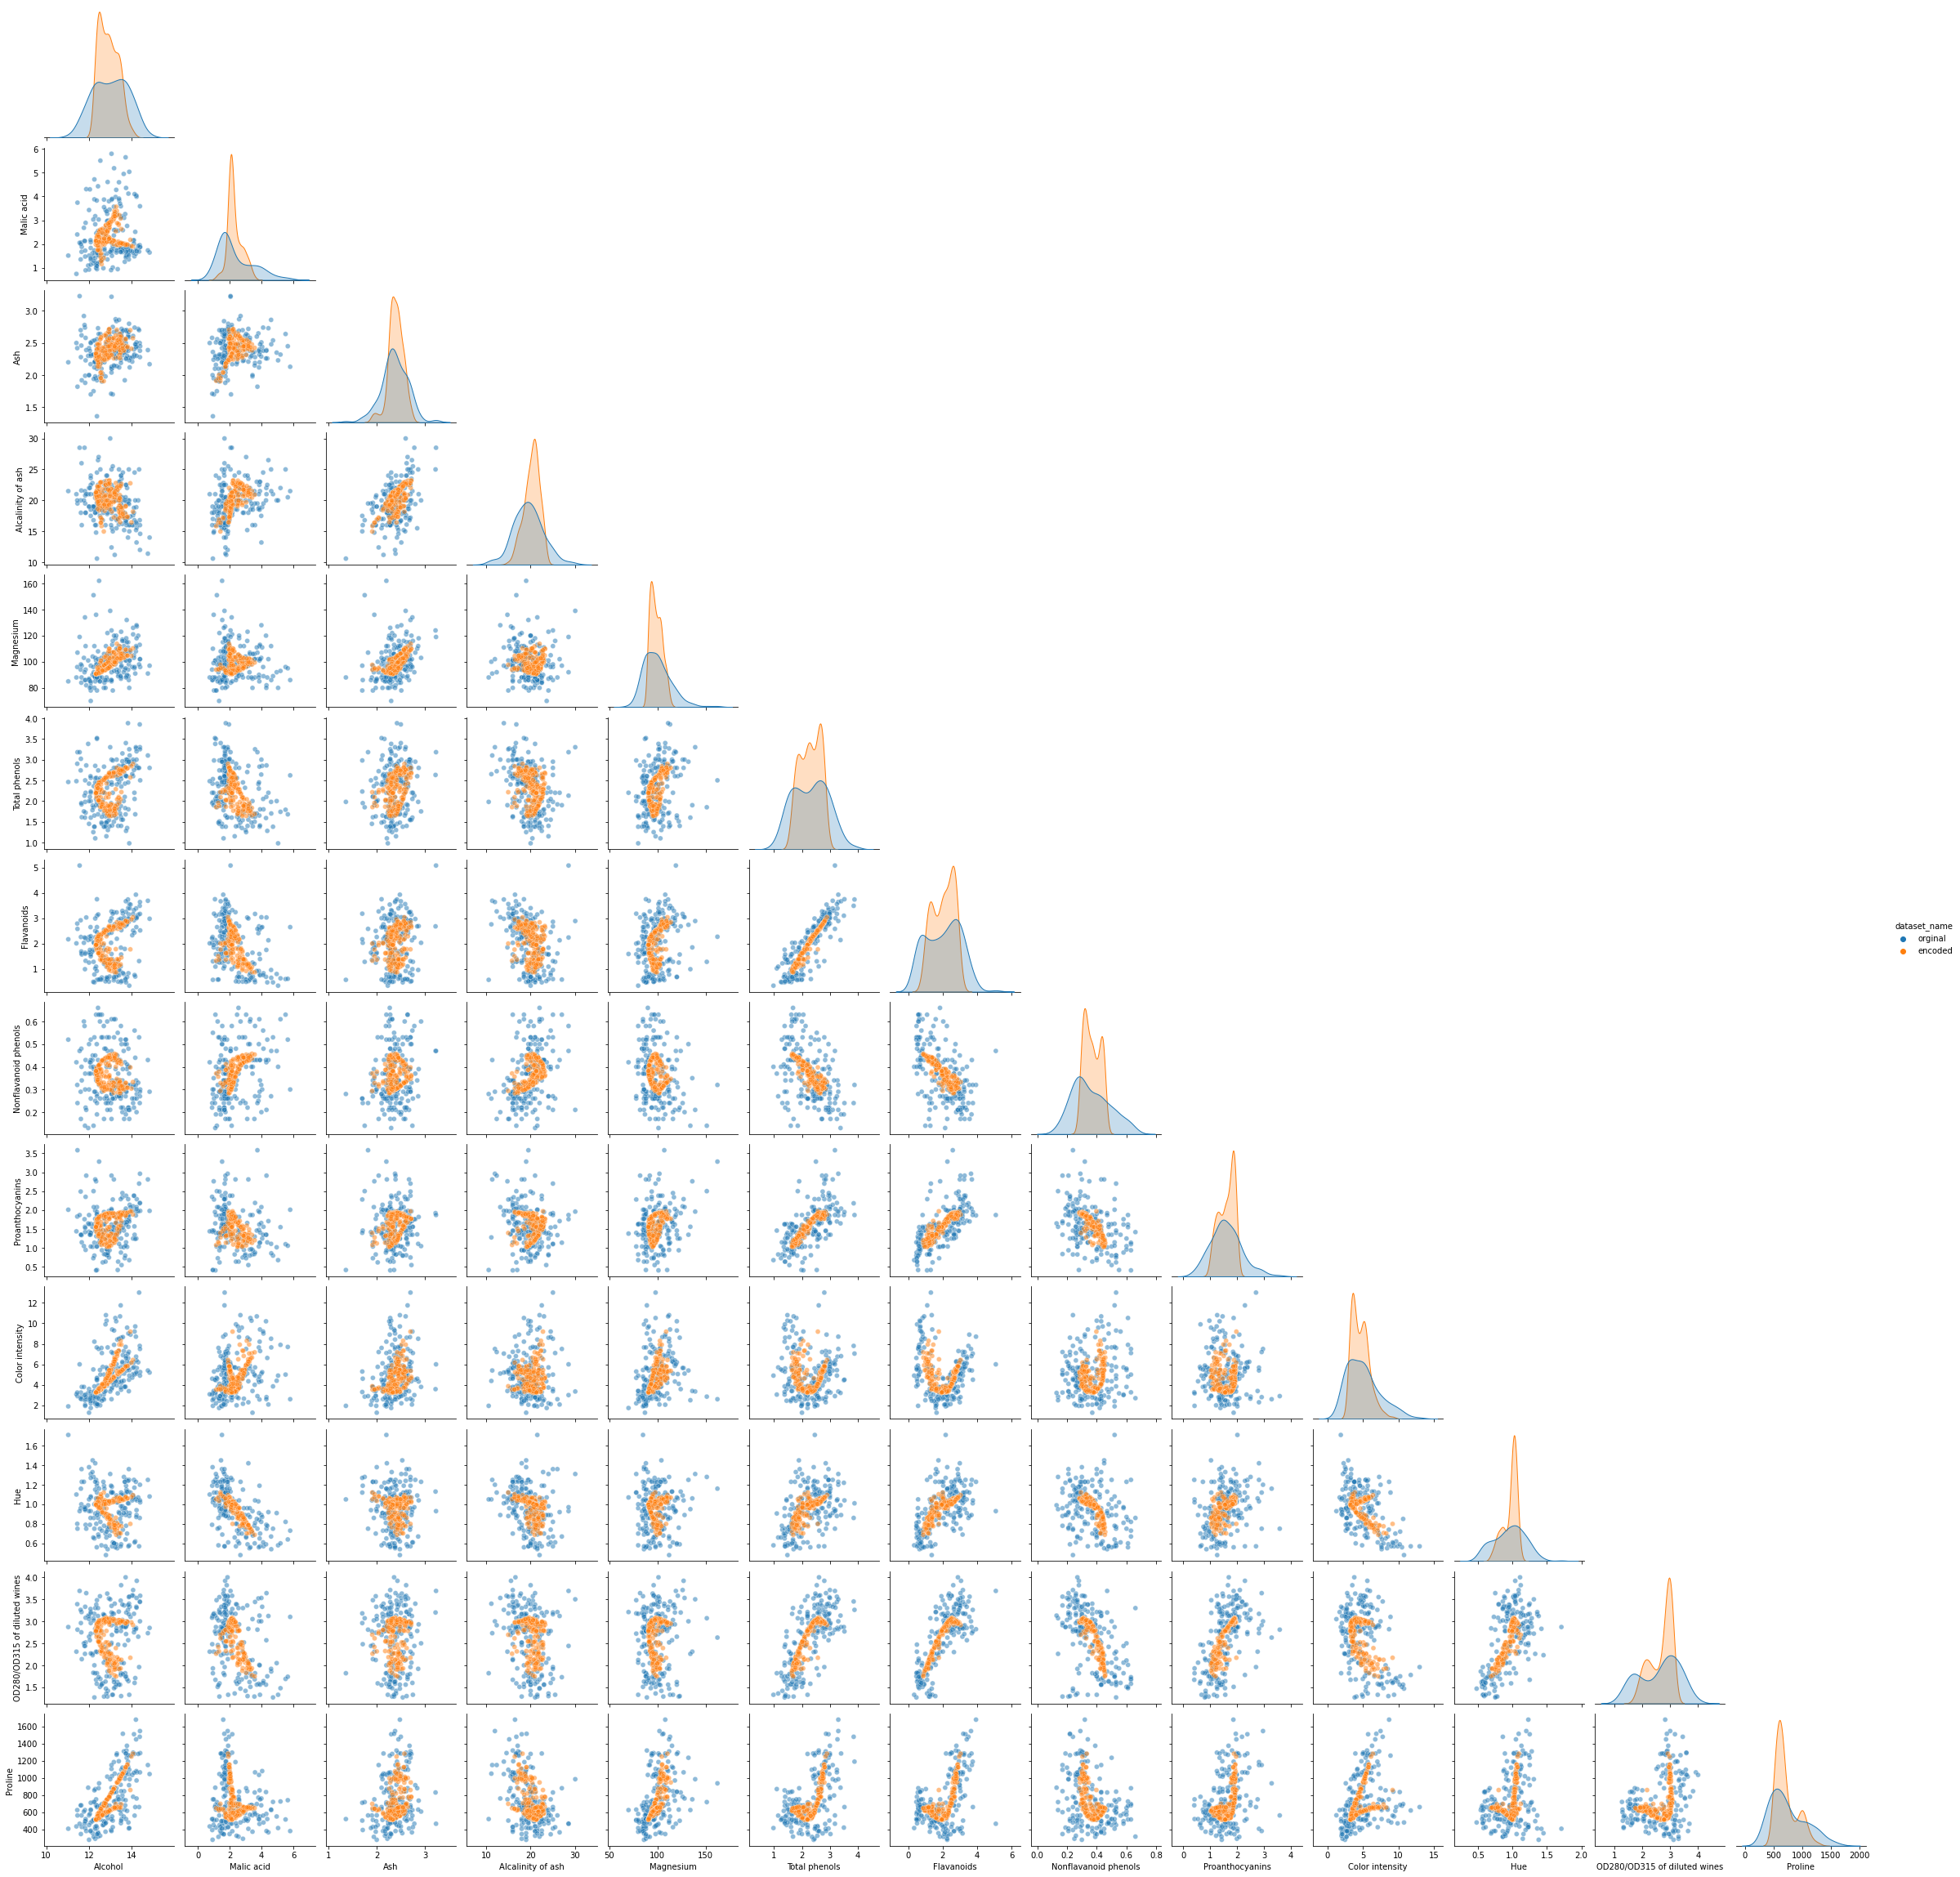

In [40]:
sns.pairplot(concatenated_datasets, hue="dataset_name", kind="scatter", plot_kws=dict(alpha=0.5),corner=True)


In [41]:
#sns.pairplot(decoded_df, diag_kind="kde")

In [42]:
#sns.pairplot(orginal_df)

In [43]:
tmp_2=df_wine.iloc[37:38,1:]
tmp_2=tmp_2.to_numpy(dtype=np.float32)
orginal_2=tmp_2
tmp_2=stdcs.transform(tmp_2)
tmp_2=torch.from_numpy(tmp_2)
with torch.no_grad():
    result_encoded_features_2, z_mean_2, z_log_var_2, result_decoded_features_2=model(tmp_2.to(device=DEVICE))
result_2=result_decoded_features_2.cpu().detach().numpy()
result_2=stdcs.inverse_transform(result_2)

In [44]:
orginal_2=orginal_2.flatten()
result_2=result_2.flatten()

In [45]:
df=pd.DataFrame(np.stack((orginal_2,result_2)), columns=['Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline'])
df

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,13.050000,1.650000,2.550000,18.000000,98.000000,2.450000,2.430000,0.290000,1.44000,4.250000,1.120000,2.510000,1105.000000
1,13.008235,2.132883,2.366661,18.955254,100.169411,2.609043,2.553328,0.303254,1.92269,4.404048,1.022914,3.045362,810.064209


In [46]:
encoded_features=[]
labels_encoded_features=[]
for index, (value, labels) in enumerate(train_loader):
    with torch.no_grad():
        tmp_encoded_features, z_mean, z_log_var, decoded =model(value.to(device=DEVICE))
        encoded_features.extend(tmp_encoded_features.cpu().detach().numpy())
        labels_encoded_features.extend(labels.cpu().detach().numpy())
encoded_features=np.asarray(encoded_features)

print(encoded_features.shape)

(136, 9)


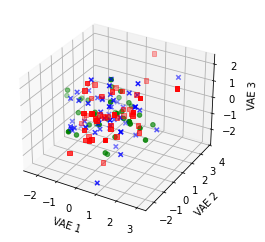

In [47]:
#PRZESTRZEŃ UKRYTA VAE
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

fig=plt.figure()
ax=fig.add_subplot(projection='3d')
for l, c, m in zip(np.unique(labels_encoded_features), colors, markers):
    ax.scatter(encoded_features[labels_encoded_features==l,0],encoded_features[labels_encoded_features==l,1],encoded_features[labels_encoded_features==l,2],marker=m,label=l,c=c)

ax.set_xlabel('VAE 1')
ax.set_ylabel('VAE 2')
ax.set_zlabel('VAE 3')

plt.show()